## Final rescale for paper 1

Since all our scaling is based of the squeezing/stretching of isopyncals and isoconcetration lines near the head, I moved the virtual station DnC to be close to the head (UwH for "upwelling near the head"). The sum of the max stratification above 100 m (rim?) and min stratification below 100 m correlates well with the upwelling flux $\Phi$. So , the stratification, and for that matter tracer gradient, that we want to scale is the one at the head and not at DnC (around mid length). In this notebook I rescale N above, N below, dC/dz above and below and C. 

In [1]:
#import gsw as sw # Gibbs seawater package

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
from matplotlib.ticker import FormatStrFormatter
from netCDF4 import Dataset
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import scipy.stats
import warnings
warnings.filterwarnings("ignore")
import xarray as xr

import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
sns.set_context('talk')
sns.set_style('white')

In [3]:
CanyonGrid='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 
time = CanyonStateOut.variables['T']
RC = CanyonGridOut.variables['RC']


In [4]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Hs = 149.8 # Shelf break depth
s = 0.005 # shelf slope
Wr = 13756.1
W = 22044.8 # mid-length width
Hh= 98.8 # head depth
Hr = 108.1 # rim depth at UwH

# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,W=8300,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*W))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)

def smoothHS(hdepth, epsilon, Hr, kbg, kcan):
    '''Build smooth Heaviside function at mid-depth points hdepth ''' 
    
    KK = kbg + kcan*(0.5 + 
                     0.5*(hdepth-Hr)/epsilon + 
                     1./(2*np.pi)*np.sin(np.pi*(hdepth-Hr)/(epsilon)))
    KK[hdepth < Hr - epsilon] = kbg
    KK[hdepth >= Hr + epsilon] = kbg + kcan
    return KK

In [5]:
# Information for all runs is stored in canyon_records.py
lib_path = os.path.abspath('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
records = canyon_records.main()

import nocanyon_records 
recordsNoC = nocanyon_records.main()

### Not all runs are used to fit all variables

**records_dyn** has all runs where f, N or U vary. USe this list to fit upwelling flux $\Phi$ and modify *Howatt and Allen 2013*.

**records_step** has all runs in records_dyn plus the runs with a step Kv profile. Use this list to fit $\Phi$ with scaled N.

**records_kv** has all runs with step Kv profile. Use this list to fit N below for step Kv runs.

**records_nokv** has all runs except the ones with step Kv profile. Use this list to fit N below.

In [6]:
# Indices of all runs that will be considered for paper 1

select_rec = [0,1,2,3,4,5,51,6,7,8,9,10,17,18,19,20,21,
              22,23,24,25,26,27,29,30,31,32,33,
              34,35,38,39,41,42,43,44,45,46,47,48,49]

for ii in select_rec:
    print(ii,records[ii].label2, records[ii].name)
    

0 base case CNTDIFF_run38
1 $\uparrow$ $K_{bg}$ CNTDIFF_run37
2 $\uparrow \uparrow$ $K_{bg}$ CNTDIFF_run36
3 $\uparrow$ $N_0$ CNTDIFF_run45
4 $\uparrow \uparrow$ $N_0$ CNTDIFF_run73
5 $\Downarrow$ $N_0$ CNTDIFF_run75
51 $\downarrow \downarrow N_0$ CNTDIFF_run81
6 $\downarrow$ $N_0$ CNTDIFF_run79
7 $\uparrow f$ CNTDIFF_run67
8 $\downarrow \downarrow$ $f$ CNTDIFF_run51
9 $\downarrow f$ CNTDIFF_run69
10 $\Downarrow f$ CNTDIFF_run71
17 $\downarrow$ U LOWER_BF_run01
18 $\downarrow \downarrow$ U LOW_BF_run01
19 $\Downarrow$ U LOWEST_BF_run01
20 $\Downarrow$ U, $\downarrow \downarrow$ $N_0$ LOWEST_BF_run03
21 $\Downarrow$ U, $\uparrow \uparrow$ $N_0$ LOWEST_BF_run05
22 $\Downarrow$ U, $\Downarrow$ $f$ LOWEST_BF_run07
23 $\Downarrow$ U, $\uparrow \uparrow K_{can}$ LOWEST_BF_run11
24 $K_{can}$ Monterey (bot) 3DVISC_REALISTIC_run01
25 $K_{can}$ Eel (bot) 3DVISC_REALISTIC_run02
26 $K_{can}$ Monterey 3DVISC_REALISTIC_run03
27 $K_{can}$ Ascension (bot) 3DVISC_REALISTIC_run05
29 $\Uparrow \Uparrow K

In [7]:
# records_dyn has all the runs without the ones where K_bg changes. Use these ones for fitting the data HA2013
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22]
records_dyn = []
for ii in ind:
    records_dyn.append(records[ii])

# records_step has all the runs in records_dyn plus the step runs (use these to fit Phi with Nmean)
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,38,39,45,46,47,48,49]
records_step = []
for ii in ind:
    records_step.append(records[ii])

# records_epsilon has all the runs in records_step plus the epsilon runs (use these to fit Nmax+Nmin)
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,
       34,38,39,41,42,43,44,45,46,47,48,49]
records_epsilon = []
for ii in ind:
    records_epsilon.append(records[ii])

# records_real has all the runs in records_epsilon plus the realistic runs
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,
       34,38,41,42,39,43,44,45,46,47,48,49,24,25,26,27]
records_real = []
for ii in ind:
    records_real.append(records[ii])

# records_diffusivity has all the runs with step and epsilon kv profiles; it does not have the dynamics runs
ind = [29,30,31,32,33,34,38,39,41,42,43,44,45,46,47,48,49]
records_diffusivity = []
for ii in ind:
    records_diffusivity.append(records[ii])

    
# records_kv has the runs with step kv profile
ind = [32,37,38,44,45,46,47,48] 

records_kv = []
for ii in ind:
    records_kv.append(records[ii])

# records_nokv has the runs without step kv profile
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,34,41,42,43,44]
       
records_nokv = []
for ii in ind:
    records_nokv.append(records[ii])

# records3 has all the runs without the ones where K_bg changes and run with low U high N.
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,21,22]
records3 = []
for ii in ind:
    records3.append(records[ii])



In [8]:
records_sel = []

for ind in select_rec:
    records_sel.append(records[ind])
    file = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    dfcan = pd.read_csv(file)
    records[ind].HCW = dfcan['HCW']
    records[ind].HCWTr1 = dfcan['HCWTr1']
    records[ind].TrMass = dfcan['TrMassHCW']
    records[ind].TrMassTr1 = dfcan['TrMassHCWTr1']
    records[ind].TrMassTr2 = dfcan['TrMassHCWTr2']
    records[ind].TrMassTot = dfcan['TotTrMass']
    records[ind].TrMassTotTr2 = dfcan['TotTrMassTr2']
    records[ind].TrMassTotTr1 = dfcan['TotTrMassTr1']
   

In [9]:
records_selNoC = []
for ind in select_rec:
    records_selNoC.append(recordsNoC[ind])
    file = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(recordsNoC[ind].exp_code,
                                                                                recordsNoC[ind].exp_code,
                                                                                recordsNoC[ind].run_num))
    dfcan = pd.read_csv(file)
    recordsNoC[ind].HCW = dfcan['HCW']
    recordsNoC[ind].HCWTr1 = dfcan['HCWTr1']
    recordsNoC[ind].TrMass = dfcan['TrMassHCW']
    recordsNoC[ind].TrMassTr1 = dfcan['TrMassHCWTr1']
    recordsNoC[ind].TrMassTr2 = dfcan['TrMassHCWTr2']
    recordsNoC[ind].TrMassTot = dfcan['TotTrMass']
    recordsNoC[ind].TrMassTotTr2 = dfcan['TotTrMassTr2']
    recordsNoC[ind].TrMassTotTr1 = dfcan['TotTrMassTr1']


In [10]:
t=6.5
keys2 = ['N_tt12','N_tt14']
stname = 'UwH' # UwHStation at downstream head side of canyon

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    Nab = 0
    Nbe = 0
    Nrim = 0 
    Nmean = 0
    Nab = np.empty(len(keys2))
    Nbe = np.empty(len(keys2))
    
    for key,ii in zip(keys2, range(len(keys2))):
        Nab[ii] = np.max(df[keys2[ii]][:]) #0:20
        Nbe[ii] = np.min(df[keys2[ii]][20:23]) #20:23
        
    records[ind].Nab = np.mean(Nab)
    records[ind].Nbe = np.mean(Nbe)
    records[ind].Nab_std = np.std(Nab)
    records[ind].Nbe_std = np.std(Nbe)
        

In [11]:
keys2 = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16','dTrdz_tt18']
stname = 'UwH' # Station at downstream head side of canyon

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    dTrab = 0
    dTrbe = 0
          
    for key,ii in zip(keys2, range(len(keys2))):
        dTrab = dTrab + np.min(df[keys2[ii]][:]) #0:20
        dTrbe = dTrbe + np.max(df[keys2[ii]][20:23]) #20:24
    
    records[ind].dTr_ab = dTrab/  len(keys2)
    records[ind].dTr_be = dTrbe/  len(keys2)
    records[ind].dTr0 = df['dTrdz_tt00'][15]

In [12]:
keys2 = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16','Tr_profile_tt18']
stname = 'UwH' # Station at downstream head side of canyon

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    Nab = np.zeros(len(keys2))
          
    for key,ii in zip(keys2, range(len(keys2))):
        Nab[ii] = np.nanmean(df[keys2[ii]][19:21]) # rim depth
        
    records[ind].Tr = np.nanmean(Nab)
    records[ind].Tr_std = np.std(Nab)
    records[ind].Tr0 = df['Tr_profile_tt00'][21]
    
    
   

## Stratification and upwelling flux

In previous notebooks I found that the upwelling flux is porportional to an effective stratification $N_{eff}$ given by the sum of the maximum stratification above the rim, near the head and the minimum stratification below the rim. 

$$N_{eff} = {0.67N_{max}+0.33N_{min}}$$

So first, we scale $N_{max}$ and $N_{min}$ similarly as we did in the previous version of the paper: we use the squeezing and stretching of isopycnals given by $Z_{dif}$ and we add the effect of the smoothness of the diffusivity profile $\epsilon$.

Once we get both N's, we can scale $N_{eff}$ and use it in the depth scale $D_h$ in the scaling for $\Phi$ by Howatt and Allen as $D_{eff}=fL/N_{eff}$, with proper fitting parameters.

24 nan 3DVISC_REALISTIC_run01 1
25 15.4527604635 3DVISC_REALISTIC_run02 1
26 2.98673905489 3DVISC_REALISTIC_run03 1
27 3.83702003787 3DVISC_REALISTIC_run05 1
29 71.4192435289 3DVISC_REALISTIC_run07 1
30 46.6022276505 3DVISC_REALISTIC_run08 1
31 33.3600588013 3DVISC_REALISTIC_run09 1
32 23.6619152517 3DVISC_REALISTIC_run10 1
33 58.4526424279 3DVISC_REALISTIC_run11 1
34 27.3005999551 3DVISC_REALISTIC_run12 1
38 23.5793129671 3DVISC_REALISTIC_run16 1
39 52.937548111 3DVISC_REALISTIC_run17 1
41 14.6703856388 3DVISC_REALISTIC_run19 1
42 7.44877314231 3DVISC_REALISTIC_run20 1
43 32.9362541922 3DVISC_REALISTIC_run21 1
44 16.7231245091 3DVISC_REALISTIC_run22 1
45 66.9864463903 3DVISC_REALISTIC_run23 1
46 82.0584182153 3DVISC_REALISTIC_run24 1
47 37.3949729242 3DVISC_REALISTIC_run25 1
48 16.5886708328 3DVISC_REALISTIC_run26 1
49 74.9024966206 3DVISC_REALISTIC_run27 1
-142.5
-132.5
-137.5 27.0
-135


Text(0.5,1,'Kv profiles at UwH')

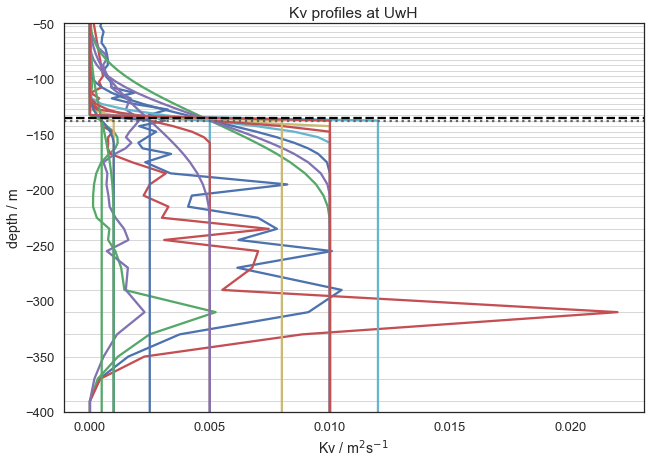

In [13]:
# Get kv form initial files
fig, ax = plt.subplots(1,1)

for ii in range(len(RC)):
    ax.axhline(RC[ii], linestyle='-', color='0.7', linewidth=0.5)

records_kv_files = [24,25,26,27,
                    29,30,31,32,33,34,38,39,41,42,43,44,45,46,47,48,49]

kv_dir = '/ocean/kramosmu/Building_canyon/BuildCanyon/Stratification/616x360x90/'
ini_kv_files = [kv_dir + 'KrDiff_Mty_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_Eel_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_Mty_rim_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_Asc_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e10_kv1E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e25_kv1E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e50_kv1E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e100_kv1E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e15_kv1E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e75_kv1E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_kv1E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_kv5E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e25_kv1E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e100_kv1E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e25_kv5E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e100_kv5E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_kv8E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_exact1p2E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_kv2p5E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_kv5E4_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_exact_nosmooth_90zlev_616x360_Quad.bin',
                ]

dt = np.dtype('>f8')  # float 64 big endian
st = [240, 200] # y, x indices of UwH station
Hr = 135
dd = 1
ini_kv_profiles = np.zeros((len(ini_kv_files),nz))

for file, ii in zip(ini_kv_files, records_kv_files):
    data = np.fromfile(file, dt)
    ini_kv = np.reshape(data,(90,360,616),order='C')
    KK = ini_kv[:, st[0], st[1]] 
    ax.plot(KK[:], RC)
    
    records[ii].Zdif = (((KK[int(Hr/5)+1]-KK[int(Hr/5)-1]))*t*3600*24)**0.5
    records[ii].dk =  KK[int(Hr/5)+1]-KK[int(Hr/5)-1]
    records[ii].Kz =  KK[int(Hr/5)-4]
    records[ii].Kz_be =  KK[int(Hr/5)+4]
      
    print(ii,records[ii].Zdif, records[ii].name, dd)

ax.set_ylim(-400,-50)
ax.axhline(-Hr, linestyle = '--', color='k')
ax.axhline(RC[int(Hr/5)], linestyle = ':', color='0.4')

print(RC[int(Hr/5)+dd])
print(RC[int(Hr/5)-dd])
print(RC[int(Hr/5)], Hr/5)
print(-Hr)
ax.set_xlabel(r'Kv / m$^2$s$^{-1}$')
ax.set_ylabel('depth / m')
ax.set_title('Kv profiles at UwH')

3DVISC_REALISTIC_run07 10 0.01 0.00908245788149 1e-05
3DVISC_REALISTIC_run08 25 0.01 0.00386710758901 7.44462054951e-05
3DVISC_REALISTIC_run09 50 0.01 0.00198164801144 0.00149486019618
3DVISC_REALISTIC_run10 100 0.01 0.000996948421254 0.0030714462055
3DVISC_REALISTIC_run11 15 0.01 0.00608388783263 1e-05
3DVISC_REALISTIC_run12 75 0.01 0.00132714166294 0.00249143102765
3DVISC_REALISTIC_run16 5 0.001 0.00099 1e-05
3DVISC_REALISTIC_run19 25 0.001 0.00038322687819 1.63865609049e-05
3DVISC_REALISTIC_run20 100 0.001 9.87966903946e-05 0.000313386560905
3DVISC_REALISTIC_run17 5 0.005 0.00499 1e-05
3DVISC_REALISTIC_run21 25 0.005 0.00193161830522 4.21908473895e-05
3DVISC_REALISTIC_run22 100 0.005 0.000497975237443 0.00153919084739
3DVISC_REALISTIC_run23 5 0.008 0.00799 1e-05
3DVISC_REALISTIC_run24 5 0.012 0.01199 1e-05
3DVISC_REALISTIC_run25 5 0.0025 0.00249 1e-05
3DVISC_REALISTIC_run26 5 0.0005 0.00049 1e-05
3DVISC_REALISTIC_run27 5 0.01 0.00999 1e-05
3DVISC_REALISTIC_run01 10 0.0091 -0.0004016

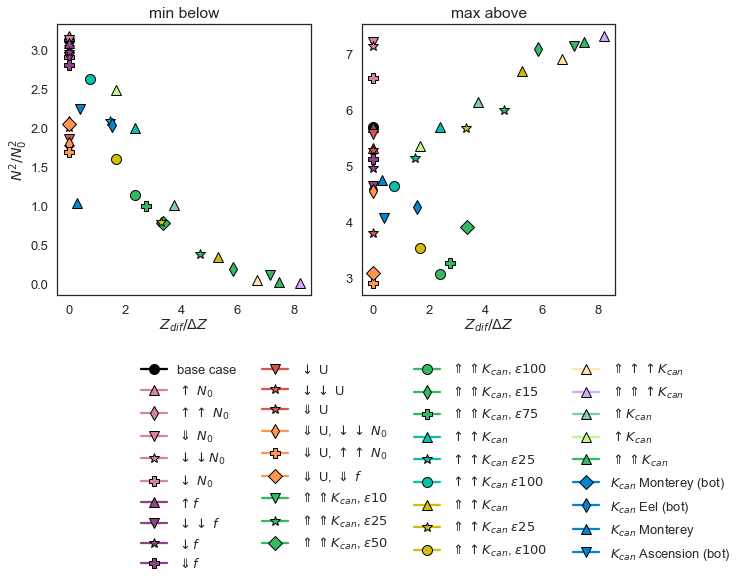

In [14]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (10,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:

    Dz = abs(RC[int(Hr/5)+1]-RC[int(Hr/5)-1])
    rec.Z = ((rec.f*rec.u_mod*F(Ro(rec.u_mod,rec.f,R))*L)**(0.5))/rec.N
    
    if rec.kv == rec.kbg:
        rec.Zdif = 0
        rec.Sdif_min = np.exp(-0.1*rec.Zdif/Dz)
        rec.dk = 0
        rec.Kz = 1E-5
        rec.Kz_be = 1E-5
        
        rec.Sdif_max = (rec.Zdif/Dz)*np.exp(-(rec.Kz*t*3600*24)/((rec.epsilon)**2))
    
    else:
        rec.Sdif_min = np.exp(-0.1*rec.Zdif/Dz)
        rec.Sdif_max = (rec.Zdif/Dz)*np.exp(-(rec.Kz*t*3600*24)/((rec.epsilon)**2))
        print(rec.name,rec.epsilon, rec.kv,rec.dk,rec.Kz )    
    
    rec.S_max = (rec.Z/Hh)*np.exp(-rec.Kz*t*3600*24/rec.Z**2)
    rec.S_min = (rec.Z/Hh)*np.exp(-rec.Kz_be*t*3600*24/rec.Z**2)
    
    plt1 = ax0.plot(rec.Zdif/Dz,
                    (rec.Nbe)**2/(rec.N)**2,
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
    plt1 = ax1.plot((rec.Zdif/Dz),
                    ((rec.Nab)**2/(rec.N)**2),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
           

ax0.set_ylabel('$N^2/N^2_0$',labelpad=0.5)
ax0.set_xlabel(r'$Z_{dif}/\Delta Z$',labelpad=0.5)
ax1.set_xlabel(r'$Z_{dif}/\Delta Z$',labelpad=0.5)

ax0.set_title('min below')
ax1.set_title('max above')

ax1.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)

We fit a line through the step runs and dynamical runs:

In [15]:
X1_be = np.array([rec.S_min for rec in records_epsilon])
X2_be = np.array([rec.Sdif_min for rec in records_epsilon])
Y_be = np.array([(rec.Nbe)**2/(rec.N**2) for rec in records_epsilon])

X1_ab = np.array([rec.S_max for rec in records_epsilon])
X2_ab = np.array([rec.Sdif_max for rec in records_epsilon])
Y_ab = np.array([(rec.Nab)**2/(rec.N**2) for rec in records_epsilon])

In [16]:
from sklearn import linear_model
reg_be = linear_model.LinearRegression()
reg_be.fit (np.transpose([X1_be,X2_be]),np.transpose(Y_be) )
print(reg_be.coef_)
print(reg_be.intercept_)

reg_ab = linear_model.LinearRegression()
reg_ab.fit (np.transpose([X1_ab, X2_ab]),np.transpose(Y_ab) )
print(reg_ab.coef_)
print(reg_ab.intercept_)


[ 2.96167833  2.63312925]
-1.56141336783
[ 8.165202    0.21538383]
0.810635952505


In [17]:
# save values of N_eff and Phi
for rec in records_sel:
   
    can_eff = rec.HCW
    Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    Phi_std = np.std(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    rec.Phi = Phi
    rec.Phi_std = Phi_std

for rec in records_real:

    rec.Nbe_scaled =  np.sqrt(reg_be.coef_[0]*rec.S_min +
                              reg_be.coef_[1]*rec.Sdif_min +
                              reg_be.intercept_)*rec.N
    rec.Nab_scaled =  np.sqrt(reg_ab.coef_[0]*rec.S_max +
                              reg_ab.coef_[1]*rec.Sdif_max +
                              reg_ab.intercept_)*rec.N
     
    if  (reg_be.coef_[0]*rec.S_min+ reg_be.coef_[1]*rec.Sdif_min +
         reg_be.intercept_)< 0 :
        rec.N_eff_scaled = (0.75*rec.Nab_scaled)
    else:
        rec.N_eff_scaled =  (0.75*rec.Nab_scaled + 0.25*rec.Nbe_scaled) 
    
    rec.Neff = (0.75*rec.Nab+0.25*rec.Nbe)
    

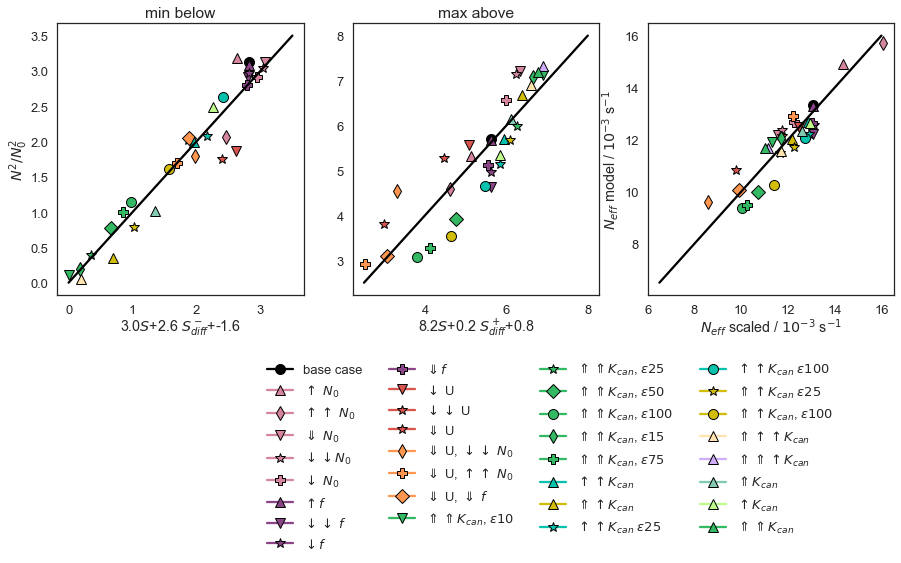

In [18]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (15,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 3)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[0,2])


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_epsilon:
    
    plt1 = ax0.plot(rec.Nbe_scaled**2/rec.N**2,(rec.Nbe)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
      
    plt1 = ax1.plot(rec.Nab_scaled**2/rec.N**2,(rec.Nab)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2) 
    
ax0.plot(np.linspace(0,3.5,20),np.linspace(0,3.5,20), 'k-')
ax1.plot(np.linspace(2.5,8,20),np.linspace(2.5,8,20), 'k-')

ax0.set_ylabel('$N^2/N^2_0$',labelpad=0.5)
ax0.set_xlabel(r'%1.1f$S$+%1.1f $S^-_{diff}$+%1.1f' %(reg_be.coef_[0], reg_be.coef_[1], reg_be.intercept_)
               ,labelpad=0.5)
ax1.set_xlabel(r'%1.1f$S$+%1.1f $S^+_{diff}$+%1.1f' %(reg_ab.coef_[0], reg_ab.coef_[1], reg_ab.intercept_)
               ,labelpad=0.5)


ax1.set_title('max above')
ax0.set_title('min below')

for rec in records_epsilon:
    plt1 = ax2.plot(rec.N_eff_scaled/1E-3,(rec.Neff)/1E-3,
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
ax2.plot(np.linspace(0.0065, 0.016, 20)/1E-3,np.linspace(0.0065, 0.016, 20)/1E-3,'k-')
ax2.set_ylabel('$N_{eff}$ model / $10^{-3}$ s$^{-1}$')
ax2.set_xlabel('$N_{eff}$ scaled / $10^{-3}$ s$^{-1}$',labelpad=0.1)
ax1.legend(bbox_to_anchor=(2,-0.2), ncol=4)



In [19]:
# records_epsilon has all runs in dyn, step and the ones where epsilon changes.

for param in np.linspace(0.6, 1.5, 60):
    for rec in records_real:
        Se = (s*rec.N)/(rec.f*((F(Ro(rec.u_mod,rec.f,Wr))/Ro(rec.u_mod,rec.f,L))**(1/2)))
        rec.X = (F(Ro(rec.u_mod,rec.f,Wr))**(3/2))*(Ro(rec.u_mod,rec.f,L)**(1/2))*((1-param*Se)**3)

        rec.Phi_nonDim = rec.Phi/(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))
        
    Y_array = np.array([rec.Phi_nonDim for rec in records_epsilon])
    X_array = np.array([rec.X for rec in records_epsilon])

    slope2, intercept2, r_value2, p_value2, std_err2 = scipy.stats.linregress(X_array,Y_array)

    print('Using parameter %1.2f: slope = %1.2f, intercept = %1.3f, r-value = %1.3f' %(param, slope2, intercept2, r_value2))

Using parameter 0.60: slope = 3.65, intercept = -0.016, r-value = 0.872
Using parameter 0.62: slope = 3.81, intercept = -0.018, r-value = 0.883
Using parameter 0.63: slope = 3.98, intercept = -0.019, r-value = 0.893
Using parameter 0.65: slope = 4.14, intercept = -0.020, r-value = 0.903
Using parameter 0.66: slope = 4.30, intercept = -0.021, r-value = 0.912
Using parameter 0.68: slope = 4.47, intercept = -0.021, r-value = 0.921
Using parameter 0.69: slope = 4.64, intercept = -0.022, r-value = 0.929
Using parameter 0.71: slope = 4.80, intercept = -0.022, r-value = 0.936
Using parameter 0.72: slope = 4.97, intercept = -0.022, r-value = 0.943
Using parameter 0.74: slope = 5.14, intercept = -0.022, r-value = 0.949
Using parameter 0.75: slope = 5.30, intercept = -0.022, r-value = 0.954
Using parameter 0.77: slope = 5.47, intercept = -0.022, r-value = 0.958
Using parameter 0.78: slope = 5.63, intercept = -0.021, r-value = 0.962
Using parameter 0.80: slope = 5.79, intercept = -0.021, r-value 

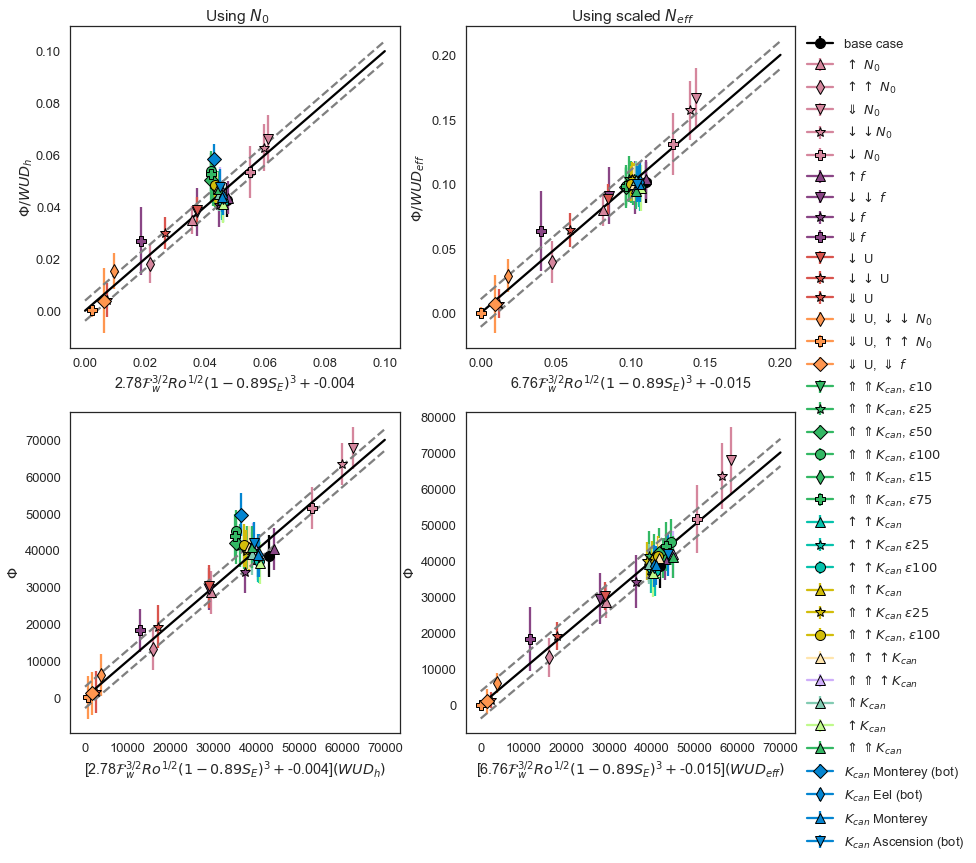

In [20]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (13,13)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(2, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])

slope = 2.78
param = 0.89
intercept = -0.004

slope2 = 6.76
param2 = 0.89
intercept2 = -0.015

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
    
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u_mod,rec.f,Wr))/Ro(rec.u_mod,rec.f,L))**(1/2)))
    HA2013=((slope*(F(Ro(rec.u_mod,rec.f,Wr))**(3/2))*(Ro(rec.u_mod,rec.f,L)**(1/2))*((1-param*Se)**3))+intercept)
    RA2018=((slope2*(F(Ro(rec.u_mod,rec.f,Wr))**(3/2))*(Ro(rec.u_mod,rec.f,L)**(1/2))*((1-param2*Se)**3))+intercept2)
    
    rec.HA2013 = HA2013
    rec.HA2013_sqe = (rec.Phi-rec.HA2013)**2
    
    rec.RA2018 = RA2018
    rec.RA2018_sqe = (rec.Phi-rec.RA2018)**2
    
    plt1 = ax0.errorbar(rec.HA2013,rec.Phi/(rec.u_mod*W*Dh(rec.f,L,rec.N)),
                        yerr=rec.Phi_std/(rec.u_mod*W*Dh(rec.f,L,rec.N)),
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label2)
    plt1 = ax1.errorbar(rec.RA2018,rec.Phi/(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled)),
                        yerr=rec.Phi_std/(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled)),
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label2)
    plt1 = ax2.errorbar(rec.HA2013*(rec.u_mod*W*Dh(rec.f,L,rec.N)),rec.Phi,
                        yerr=Phi_std,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label2)
    plt1 = ax3.errorbar(rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled)),rec.Phi,
                        yerr=rec.Phi_std,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label2)
# MSE ax0    
phi_array = np.array([rec.Phi/(rec.u_mod*W*Dh(rec.f,L,rec.N)) for rec in records_dyn])
sca_array = np.array([rec.HA2013 for rec in records_dyn])
x_fit = np.linspace(0,0.1, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax0.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax0.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax1    
phi_array = np.array([rec.Phi/(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled)) for rec in records_dyn])
sca_array = np.array([rec.RA2018 for rec in records_dyn])
x_fit = np.linspace(0,0.2, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

    
# MSE ax2    
phi_array = np.array([rec.Phi for rec in records_dyn])
sca_array = np.array([rec.HA2013*(rec.u_mod*W*Dh(rec.f,L,rec.N)) for rec in records_dyn])
x_fit = np.linspace(0,70000, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax2.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax2.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax3    
phi_array = np.array([rec.Phi for rec in records_dyn])
sca_array = np.array([rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled)) for rec in records_dyn])
x_fit = np.linspace(0,70000, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax3.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax3.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

xx0 = np.linspace(0,0.1,50)   
ax0.plot(xx0,xx0,'k-')
ax1.plot(np.linspace(0,0.2,50),np.linspace(0,0.2,50),'k-')

xx1 = np.linspace(0,70000,50)   
ax2.plot(xx1,xx1,'k-')
ax3.plot(xx1,xx1,'k-')

ax0.set_ylabel('Phi',labelpad=0.5)
ax0.set_ylabel('$\Phi/WUD_h$')
ax1.set_ylabel('$\Phi/WUD_{eff}$')
ax2.set_ylabel('$\Phi$')
ax3.set_ylabel('$\Phi$')

ax0.set_xlabel(r'%1.2f$\mathcal{F}_w^{3/2}Ro^{1/2}(1-%1.2f S_E)^3+$%1.3f' %(slope,param, intercept))
ax1.set_xlabel(r'%1.2f$\mathcal{F}_w^{3/2}Ro^{1/2}(1-%1.2f S_E)^3+$%1.3f' %(slope2,param2, intercept2))
ax2.set_xlabel(r'[%1.2f$\mathcal{F}_w^{3/2}Ro^{1/2}(1-%1.2f S_E)^3+$%1.3f]$(WUD_h)$' %(slope,param, intercept))
ax3.set_xlabel(r'[%1.2f$\mathcal{F}_w^{3/2}Ro^{1/2}(1-%1.2f S_E)^3+$%1.3f]$(WUD_{eff})$' %(slope2,param2, intercept2))

ax0.set_title(' Using $N_0$')
ax1.set_title(' Using scaled $N_{eff}$')

ax1.legend(bbox_to_anchor=(1,1), ncol=1)


## Tracer gradient, concentration and upwelling tracer flux

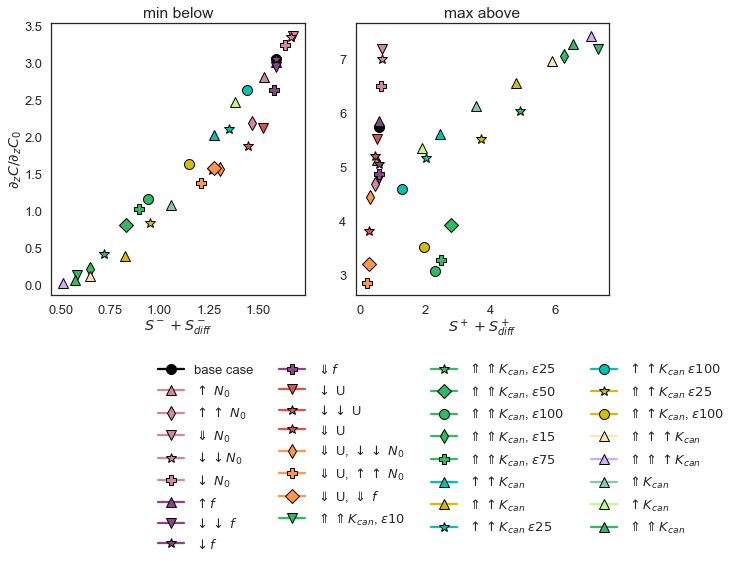

In [21]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (10,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% tracer gradient %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_epsilon:
    
    plt1 = ax0.plot(rec.S_min+rec.Sdif_min,(rec.dTr_be)/(rec.dTr0),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
    plt1 = ax1.plot(rec.S_max+rec.Sdif_max,(rec.dTr_ab)/(rec.dTr0),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
   

ax0.set_xlabel('$S^- + S^-_{diff}$',labelpad=0.5)
ax0.set_ylabel('$\partial_zC/\partial_zC_0$',labelpad=0.5)
ax1.set_xlabel('$S^+ + S^+_{diff}$',labelpad=0.5)

ax0.set_title('min below')
ax1.set_title('max above')


ax1.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)

In [22]:
X1_be = np.array([rec.S_min for rec in records_epsilon])
X2_be = np.array([rec.Sdif_min for rec in records_epsilon])
Y_be = np.array([(rec.dTr_be)/(rec.dTr0) for rec in records_epsilon])

X1_ab = np.array([rec.S_max for rec in records_epsilon])
X2_ab = np.array([rec.Sdif_max for rec in records_epsilon])
Y_ab = np.array([(rec.dTr_ab)/(rec.dTr0) for rec in records_epsilon])

In [23]:
from sklearn import linear_model
reg_be_dTr = linear_model.LinearRegression()
reg_be_dTr.fit (np.transpose([X1_be,X2_be]),np.transpose(Y_be) )
print(reg_be_dTr.coef_)
print(reg_be_dTr.intercept_)

reg_ab_dTr = linear_model.LinearRegression()
reg_ab_dTr.fit (np.transpose([X1_ab, X2_ab]),np.transpose(Y_ab) )
print(reg_ab_dTr.coef_)
print(reg_ab_dTr.intercept_)


[ 3.80741721  1.76980085]
-1.16155757993
[ 8.10393226  0.22568424]
0.807752098721


In [24]:
# save values of dTr scaled
for rec in records_sel:
    
    can_eff = rec.TrMass
    Phi_Tr = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (12,18)]))
    Phi_Tr_std = np.std(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (12,18)]))
    
    rec.PhiTr = Phi_Tr
    rec.PhiTr_std = Phi_Tr_std

for rec in records_real:
    
    rec.dTr_ab_scaled = (reg_ab_dTr.coef_[0]*rec.S_max+
                         reg_ab_dTr.coef_[1]*rec.Sdif_max+
                         reg_ab_dTr.intercept_)*rec.dTr0
    rec.dTr_be_scaled = (reg_be_dTr.coef_[0]*rec.S_min+
                         reg_be_dTr.coef_[1]*rec.Sdif_min+
                         reg_be_dTr.intercept_)*rec.dTr0
    
    if  (reg_be_dTr.coef_[0]*rec.S_min+reg_be_dTr.coef_[1]*rec.Sdif_min +
         reg_be_dTr.intercept_)< 0 :
        rec.dTr_eff_scaled = 0.8*(rec.dTr_ab_scaled)
    else:
        rec.dTr_eff_scaled = 0.8*rec.dTr_ab_scaled + 0.2*rec.dTr_be_scaled

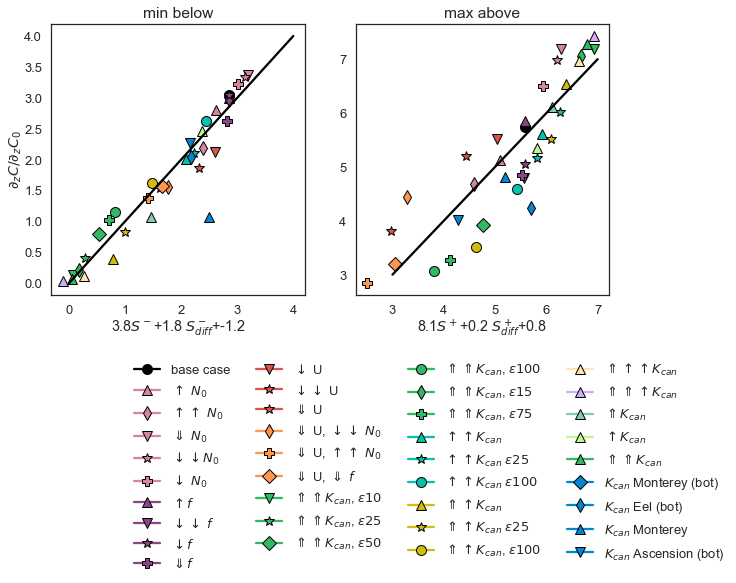

In [25]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (10,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Concentration at rim %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
    
    plt1 = ax0.plot(rec.dTr_be_scaled/rec.dTr0,(rec.dTr_be)/(rec.dTr0),
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label2)
   
    plt1 = ax1.plot(rec.dTr_ab_scaled/rec.dTr0,(rec.dTr_ab)/(rec.dTr0),
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label2)
    
      
ax0.plot(np.linspace(0,4,20),np.linspace(0,4,20), 'k-')
ax1.plot(np.linspace(3,7,20),np.linspace(3,7,20), 'k-')

ax0.set_ylabel('$\partial_zC/\partial_zC_0$',labelpad=0.5)


ax1.set_title('max above')
ax0.set_title('min below')

ax0.set_xlabel(r'%1.1f$S^-$+%1.1f $S^-_{diff}$+%1.1f' %(reg_be_dTr.coef_[0], reg_be_dTr.coef_[1], reg_be_dTr.intercept_)
               ,labelpad=0.5)
ax1.set_xlabel(r'%1.1f$S^+$+%1.1f $S^+_{diff}$+%1.1f' %(reg_ab_dTr.coef_[0], reg_ab_dTr.coef_[1], reg_ab_dTr.intercept_)
               ,labelpad=0.5)


ax1.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)

### Concentration

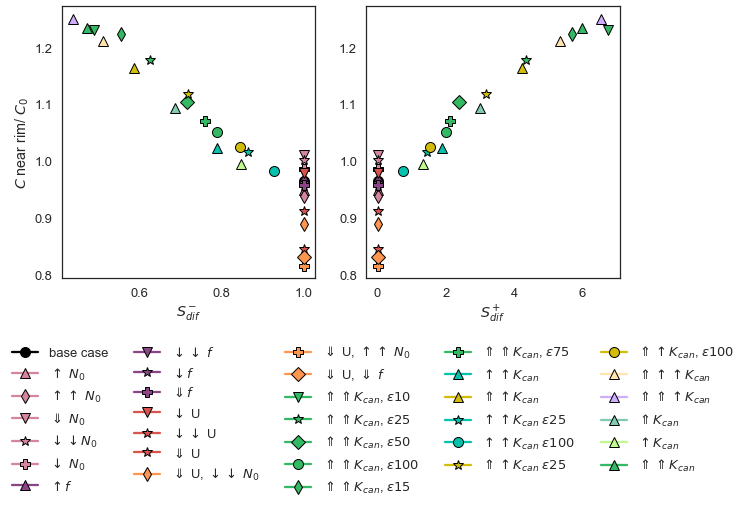

In [26]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (10,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Concentration at rim %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_epsilon:
    plt1 = ax0.plot(rec.Sdif_min,rec.Tr/rec.Tr0,
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label2)
    plt1 = ax1.plot(rec.Sdif_max,rec.Tr/rec.Tr0,
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label2)
ax0.set_ylabel('$C$ near rim/ $C_0$')
ax0.set_xlabel(r'$S^-_{dif}$')
ax1.set_xlabel(r'$S^+_{dif}$')


ax1.legend(bbox_to_anchor=(1.5,-0.2), ncol=5)


In [27]:
X1_tr = np.array([rec.S_min for rec in records_epsilon])
X2_tr = np.array([rec.Sdif_min for rec in records_epsilon])
Y_tr = np.array([(rec.Tr/rec.Tr0) for rec in records_epsilon])

reg_Tr1 = linear_model.LinearRegression()
reg_Tr1.fit (np.transpose([X1_tr,X2_tr]),np.transpose(Y_tr) )
print(reg_Tr1.coef_)
print(reg_Tr1.intercept_)

X1_tr = np.array([rec.S_max for rec in records_epsilon])
X2_tr = np.array([rec.Sdif_max for rec in records_epsilon])
Y_tr = np.array([(rec.Tr/rec.Tr0) for rec in records_epsilon])

reg_Tr2 = linear_model.LinearRegression()
reg_Tr2.fit (np.transpose([X1_tr,X2_tr]),np.transpose(Y_tr) )
print(reg_Tr2.coef_)
print(reg_Tr2.intercept_)


[ 0.2122135  -0.75282378]
1.58102305816
[ 0.26783418  0.04664062]
0.808938377828


Text(0,0.5,'$C$ near rim$/C_0')

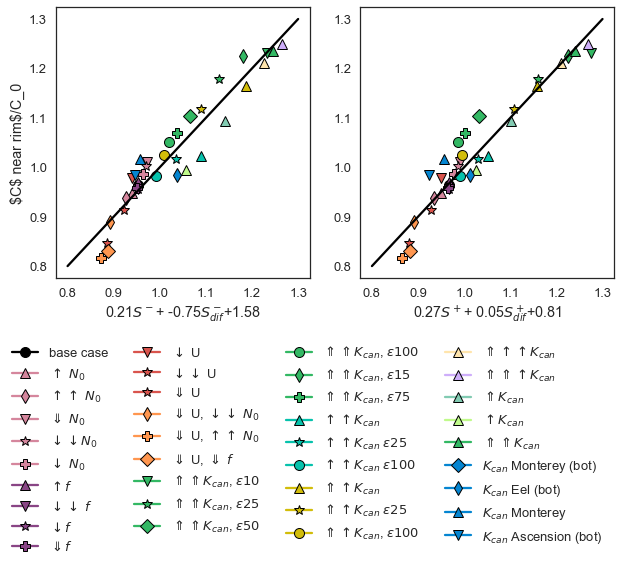

In [28]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (10,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Concentration at rim %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
    rec.Tr_scaled_min = (reg_Tr1.coef_[0]*(rec.S_min)+ reg_Tr1.coef_[1]*(rec.Sdif_min)+
                        reg_Tr1.intercept_)*rec.Tr0
    rec.Tr_scaled_max = (reg_Tr2.coef_[0]*(rec.S_max)+ reg_Tr2.coef_[1]*(rec.Sdif_max)+
                        reg_Tr2.intercept_)*rec.Tr0
    
    plt1 = ax0.plot(rec.Tr_scaled_min/rec.Tr0,
                    (rec.Tr/rec.Tr0),
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label2)
    plt2 = ax1.plot(rec.Tr_scaled_max/rec.Tr0,
                    (rec.Tr/rec.Tr0),
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label2)
    
ax0.plot(np.linspace(0.8,1.3,20),np.linspace(0.8,1.3,20),'k-')       
ax1.plot(np.linspace(0.8,1.3,20),np.linspace(0.8,1.3,20),'k-')       

ax0.legend(bbox_to_anchor=(2.2,-0.2), ncol=4)
ax0.set_xlabel(r'%1.2f$S^-$+ %1.2f$S^-_{dif}$+%1.2f' %(reg_Tr1.coef_[0],reg_Tr1.coef_[1],reg_Tr1.intercept_) )
ax1.set_xlabel(r'%1.2f$S^+$+ %1.2f$S^+_{dif}$+%1.2f' %(reg_Tr2.coef_[0],reg_Tr2.coef_[1],reg_Tr2.intercept_) )

ax0.set_ylabel(r'$C$ near rim$/C_0')

mean sq error for Phi is 0.092
mean sq error for Phi_Tr is 0.120


(2, 5)

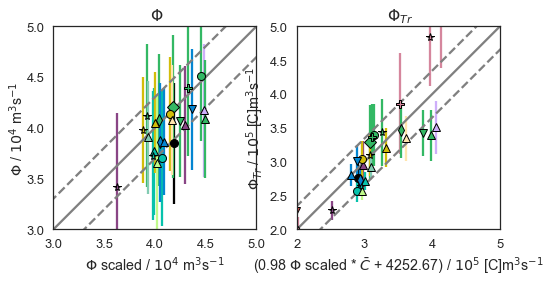

In [29]:
plt.rcParams['font.size'] = 8.0

fig,(ax0, ax1) = plt.subplots(1, 2, figsize=(8,4))

ax0.plot(np.linspace(0,8,50),np.linspace(0,8,50),'-', color='0.5')
ax1.plot(np.linspace(0,6,50),np.linspace(0,6,50),'-', color='0.5')

Y_array = np.array([rec.PhiTr for rec in records_epsilon])
X_array = np.array([rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))*
                    (rec.Tr_scaled_max) for rec in records_epsilon])
slope6, intercept6, r_value6, p_value6, std_err6 = scipy.stats.linregress(np.squeeze(X_array),np.squeeze(Y_array))
    
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
    
    rec.Phi_scaled = rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))
    rec.PhiTr_scaled = np.squeeze((slope6*rec.Phi_scaled*(rec.Tr_scaled_max))+intercept6)
    
    plt0 = ax0.errorbar(rec.Phi_scaled/1E4,
                        rec.Phi/1E4,
                        yerr=rec.Phi_std/1E4,
                        marker = rec.mstyle,
                        markersize = 8,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label2)
    plt1 = ax1.errorbar(rec.PhiTr_scaled/1E5,
                        rec.PhiTr/1E5,
                        yerr=rec.PhiTr_std/1E5,
                        marker = rec.mstyle,
                        markersize = 8,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label2)

# MSE ax0    
phi_array = np.array([rec.Phi/1E4 for rec in records_epsilon])
sca_array = np.array([rec.Phi_scaled/1E4  for rec in records_epsilon])
x_fit = np.linspace(0,8, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax0.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax0.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('mean sq error for Phi is %0.3f' %mean_sq_err)

# MSE ax1    
phiTr_array = np.array([rec.PhiTr_scaled/1E5 for rec in records_epsilon])
scaTr_array = np.array([rec.PhiTr/1E5 for rec in records_epsilon])
x_fit = np.linspace(0,6, 50)
mean_sq_err = np.mean(((phiTr_array)-(scaTr_array))**2)
upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('mean sq error for Phi_Tr is %0.3f' %mean_sq_err)

ax0.set_ylabel('Phi',labelpad=0.5)
ax0.set_ylabel('$\Phi$ / $10^4$ m$^3$s$^{-1}$')
ax1.set_ylabel('$\Phi_{Tr}$ / $10^5$ [C]m$^3$s$^{-1}$')

ax0.set_xlabel(r'$\Phi$ scaled / $10^4$ m$^3$s$^{-1}$' )
ax1.set_xlabel(r'(%1.2f $\Phi$ scaled * $\bar{C}$ + %1.2f) / $10^5$ [C]m$^3$s$^{-1}$' %(slope6, intercept6))

ax0.set_title(' $\Phi$')
ax1.set_title(' $\Phi_{Tr}$')

ax0.set_aspect(1)
ax1.set_aspect(1)
ax0.set_xlim(3,5)
ax0.set_ylim(3,5)
ax1.set_xlim(2,5)
ax1.set_ylim(2,5)


mean sq error for 0 is 0.040
mean sq error for 1 is 0.133
mean sq error for 2 is 0.034
mean sq error for 3 is 0.121


(0, 7)

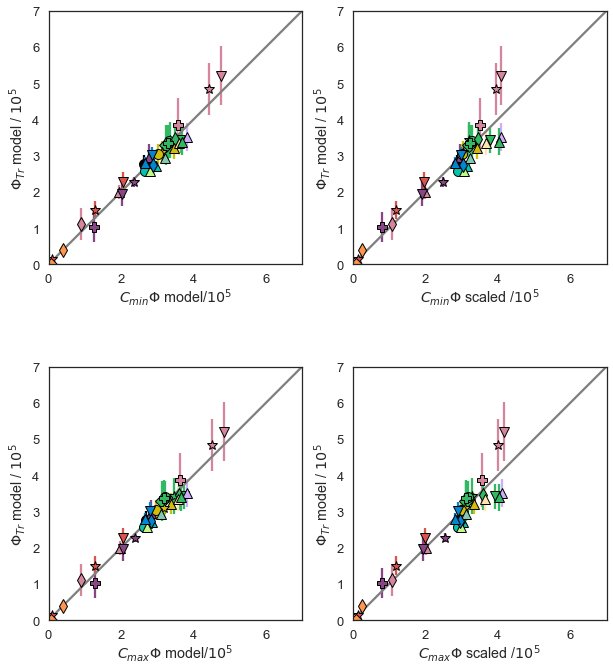

In [30]:
sns.set_context('talk')
plt.rcParams['font.size'] = 8.0

fig,((ax0, ax1),(ax2,ax3)) = plt.subplots(2, 2, figsize=(10,12))

ax0.plot(np.linspace(0,8,50),np.linspace(0,8,50),'-', color='0.5')
ax1.plot(np.linspace(0,7,50),np.linspace(0,7,50),'-', color='0.5')
ax2.plot(np.linspace(0,7,50),np.linspace(0,7,50),'-', color='0.5')
ax3.plot(np.linspace(0,7,50),np.linspace(0,7,50),'-', color='0.5')

phi_array = np.array([rec.Tr_scaled_min*rec.Phi/1E5 for rec in records_epsilon])
sca_array = np.array([rec.PhiTr/1E5  for rec in records_epsilon])
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
print('mean sq error for 0 is %0.3f' %mean_sq_err)

phi_array = np.array([rec.Tr_scaled_min*rec.Phi_scaled/1E5 for rec in records_epsilon])
sca_array = np.array([rec.PhiTr/1E5  for rec in records_epsilon])
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
print('mean sq error for 1 is %0.3f' %mean_sq_err)

phi_array = np.array([rec.Tr_scaled_max*rec.Phi/1E5 for rec in records_epsilon])
sca_array = np.array([rec.PhiTr/1E5  for rec in records_epsilon])
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
print('mean sq error for 2 is %0.3f' %mean_sq_err)

phi_array = np.array([rec.Tr_scaled_max*rec.Phi_scaled/1E5 for rec in records_epsilon])
sca_array = np.array([rec.PhiTr/1E5  for rec in records_epsilon])
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
print('mean sq error for 3 is %0.3f' %mean_sq_err)


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
    
    plt0 = ax0.errorbar(rec.Tr_scaled_min*rec.Phi/1E5,
                        rec.PhiTr/1E5,
                        yerr=rec.PhiTr_std/1E5,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label2)
    plt1 = ax1.errorbar(rec.Tr_scaled_min*rec.Phi_scaled/1E5,
                        rec.PhiTr/1E5,
                        yerr=rec.PhiTr_std/1E5,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label2)
    plt0 = ax2.errorbar(rec.Tr_scaled_max*rec.Phi/1E5,
                        rec.PhiTr/1E5,
                        yerr=rec.PhiTr_std/1E5,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label2)
    plt1 = ax3.errorbar(rec.Tr_scaled_max*rec.Phi_scaled/1E5,
                        rec.PhiTr/1E5,
                        yerr=rec.PhiTr_std/1E5,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label2)


ax0.set_xlabel('$C_{min}\Phi$ model/$10^5$',labelpad=0.5)
ax0.set_ylabel('$\Phi_{Tr}$ model / $10^5$')
ax1.set_xlabel('$C_{min}\Phi$ scaled /$10^5$',labelpad=0.5)
ax1.set_ylabel('$\Phi_{Tr}$ model / $10^5$')

ax2.set_xlabel('$C_{max}\Phi$ model/$10^5$',labelpad=0.5)
ax2.set_ylabel('$\Phi_{Tr}$ model / $10^5$')
ax3.set_xlabel('$C_{max}\Phi$ scaled /$10^5$',labelpad=0.5)
ax3.set_ylabel('$\Phi_{Tr}$ model / $10^5$')

ax0.set_aspect(1)
ax1.set_aspect(1)
ax2.set_aspect(1)
ax3.set_aspect(1)

ax0.set_xlim(0,7)
ax0.set_ylim(0,7)
ax1.set_xlim(0,7)
ax1.set_ylim(0,7)
ax2.set_xlim(0,7)
ax2.set_ylim(0,7)
ax3.set_xlim(0,7)
ax3.set_ylim(0,7)

Text(0,0.5,'$\\Phi$ scaled / $10^4$')

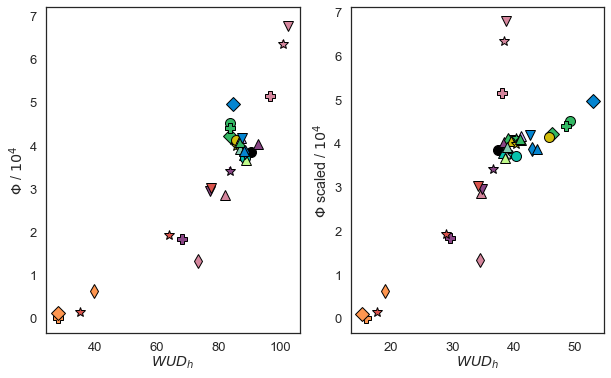

In [31]:
plt.rcParams['font.size'] = 8.0

fig,(ax0, ax1) = plt.subplots(1, 2, figsize=(10,6))

#ax0.plot(np.linspace(0,8,50),np.linspace(0,8,50),'-', color='0.5')
#ax1.plot(np.linspace(0,6,50),np.linspace(0,6,50),'-', color='0.5')

    
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
    

    plt0 = ax0.errorbar(W*rec.u_mod*Dh(rec.f,L,rec.N)/1E4,
                        rec.Phi/1E4,
                        yerr=rec.Phi_std/1E5,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label2)
    plt1 = ax1.plot(W*rec.u_mod*Dh(rec.f,L,0.77*rec.Nab+0.33*rec.Nbe)/1E4,
                    rec.Phi/1E4,
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)


ax0.set_xlabel('$WUD_h$',labelpad=0.5)
ax0.set_ylabel('$\Phi$ / $10^4$')
ax1.set_xlabel('$WUD_h$',labelpad=0.5)
ax1.set_ylabel('$\Phi$ scaled / $10^4$')

##ax0.set_xlim(0,7)
#ax0.set_ylim(0,6)
#ax1.set_xlim(0,7)
#ax1.set_ylim(0,6)

7.21757316589
7.21757316589
7.21757316589
7.21757316589
7.21757316589
7.21757316589
7.21757316589
7.21757316589
7.21757316589
7.21757316589
7.21757316589


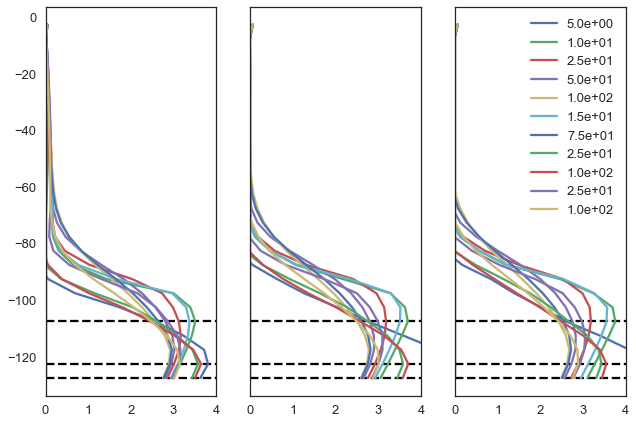

In [32]:
fig,ax = plt.subplots(1,3, sharey = True)
sns.set_style('whitegrid')
sns.set_context('talk')
keys2 = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16','Tr_profile_tt18']
stname = 'UwH' # Station at downstream head side of canyon

sns.set_palette('Spectral', 11)
for aa in ax:
    aa.axhline(RC[21], color='k', linestyle='--')   
    aa.axhline(RC[24], color='k', linestyle='--') 
    aa.axhline(RC[25], color='k', linestyle='--') 
    aa.plot(df['Tr_profile_tt00'][:]-df['Tr_profile_tt00'][:], RC[:], color='k')
    aa.set_xlim(0,4)

for rec in records_epsilon :
    if rec.epsilon>5 or rec.label2=='base case':
        filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' %
                     (rec.name,stname))
        df = pd.read_csv(filename1)
        ax[0].plot(df['Tr_profile_tt08'][:]-df['Tr_profile_tt00'][:], RC[:])
        ax[1].plot(df['Tr_profile_tt14'][:]-df['Tr_profile_tt00'][:], RC[:])
        ax[2].plot(df['Tr_profile_tt18'][:]-df['Tr_profile_tt00'][:], RC[:], label = ('%1.1e' %rec.epsilon))
        print(rec.Tr0)
ax[2].legend(loc=0)  


In [33]:
BAC_array = np.array( [ 10.51325415,   7.04127235,   3.98023107,  17.10060821,
                        16.11140949,  13.85213877,  11.05337763,   7.45709706,
                         8.86285309,   5.65066655,   8.86225387,   6.00296182,
                         1.2629518 ,   2.56032869,   0.3393471 ,   0.80551852,
                        18.04660234,  15.68697396,  11.99783917,   9.06529572,
                        17.51985767,  10.00787355,   8.11634524,  12.70847682,
                        11.95856312,  10.69285533,  16.37336583,  14.14683837,
                         9.92706316,  17.7683478 ,  18.73067473,  14.50473729,
                        11.81661951,  18.35687705,   9.23065985,  10.46856391,
                        12.61419497,  11.21805623,  11.79427934])

Area_array =   [46.5491335754,
                38.2917934328,
                26.9448332095,
                56.3817703596,
                55.182684103,
                51.9903642063,
                47.8059790456,
                37.6237425458,
                42.0910214116,
                30.7664212385,
                40.8465914993,
                32.9580624808,
                7.68000144345,
                13.6185030516,
                0.415876594776,
                2.16785064766,
                63.1188268131,
                63.1616737274,
                57.8566896409,
                46.9466246469,
                63.5691961993,
                52.4247201538,
                37.7064332802,
                51.2272862284,
                50.1747159478,
                48.4492795904,
                58.4347067957,
                57.1715659942,
                50.5199063321,
                60.9728115171,
                62.4251483425,
                54.6991068101,
                49.2334222265,
                62.0793817652,
                51.4493454317,
                49.1100729942,
                51.1891636369,
                50.6646476173,
                51.3909571846,
                ]
for rec,bac,area in zip(records_real, BAC_array, Area_array):
    rec.BAC = bac
    rec.Area = area

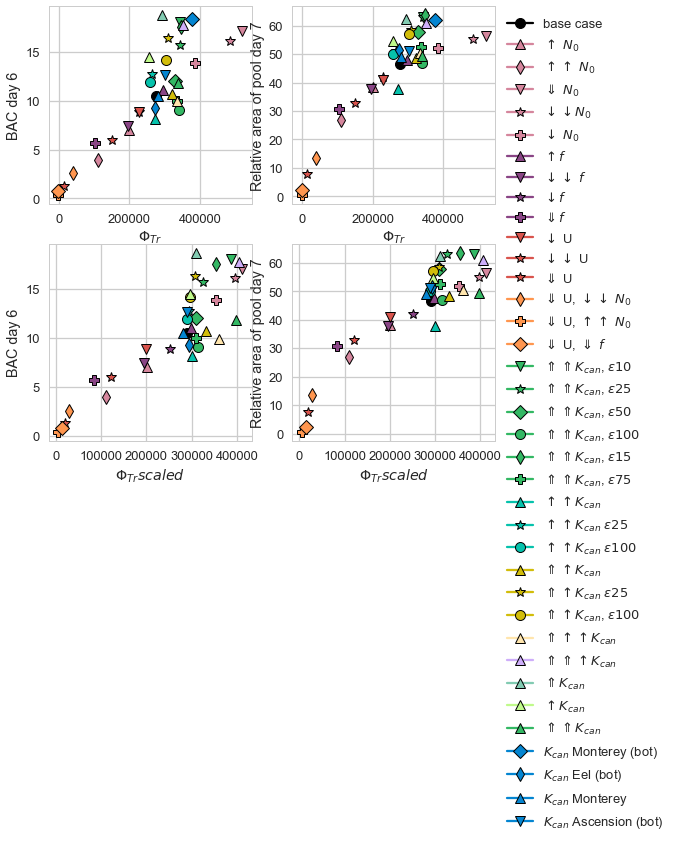

In [34]:
plt.rcParams['font.size'] = 8.0

fig,((ax0, ax1), (ax2,ax3)) = plt.subplots(2, 2, figsize=(8,8))

#ax0.plot(np.linspace(0,8,50),np.linspace(0,8,50),'-', color='0.5')
#ax1.plot(np.linspace(0,6,50),np.linspace(0,6,50),'-', color='0.5')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
  

    Y_array = np.array([rec.PhiTr_scaled for rec in records_epsilon])
    X_array = np.array([rec.BAC for rec in records_epsilon])

    slope7, intercept7, r_value7, p_value7, std_err7 = scipy.stats.linregress(np.squeeze(X_array),Y_array)

   
    plt1 = ax0.plot(rec.PhiTr,rec.BAC,
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
    plt1 = ax1.plot(rec.PhiTr, rec.Area,
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
    plt1 = ax2.plot(rec.PhiTr_scaled,rec.BAC,
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
    plt1 = ax3.plot(rec.PhiTr_scaled, rec.Area,
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)


# MSE ax1    
#phi_array = np.array([slope7*rec.PhiTr_scaled+intercept7 for rec in records_epsilon])
#sca_array = np.array([rec.BAC for rec in records_epsilon])
#x_fit = np.linspace(0,6, 50)
#mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
#upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
#lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

ax0.set_xlabel('$\Phi_{Tr}$')
ax1.set_xlabel('$\Phi_{Tr}$')

ax2.set_xlabel('$\Phi_{Tr} scaled$')
ax3.set_xlabel('$\Phi_{Tr} scaled$')

ax0.set_ylabel('BAC day 6')
ax2.set_ylabel('BAC day 6')

ax1.set_ylabel('Relative area of pool day 7')
ax3.set_ylabel('Relative area of pool day 7')

ax1.legend(bbox_to_anchor=(1,1))



## Paper Figures

### Figure (num)

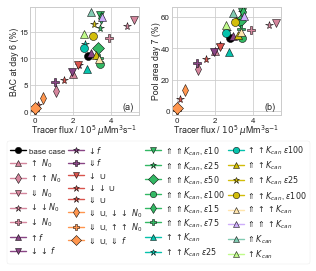

In [35]:
sns.set_context('paper')
plt.rcParams['font.size'] = 9.0
f = plt.figure(figsize = (4.5,2)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2, wspace=0.3)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])


for rec in records_real[:-5]:
  
    plt1 = ax0.plot(rec.PhiTr/1E5,rec.BAC,
                    marker = rec.mstyle,
                    markersize = 8,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2)
    plt1 = ax1.plot(rec.PhiTr/1E5, rec.Area,
                    marker = rec.mstyle,
                    markersize = 8,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2)
   

ax0.tick_params(axis='x', pad=2)
ax1.tick_params(axis='x', pad=2)
ax0.tick_params(axis='y', pad=2)
ax1.tick_params(axis='y', pad=2)

ax1.set_xlabel('Tracer flux / $10^5$ $\mu$Mm$^3$s$^{-1}$', labelpad=-0.5)
ax0.set_xlabel('Tracer flux / $10^5$ $\mu$Mm$^3$s$^{-1}$', labelpad=-0.5)

ax0.set_ylabel('BAC at day 6 (%)', labelpad=-0.5)
ax1.set_ylabel('Pool area day 7 (%)', labelpad=-0.2)
ax0.text(0.85,0.05,'(a)',transform=ax0.transAxes)
ax1.text(0.85,0.05,'(b)',transform=ax1.transAxes)

ax1.legend(bbox_to_anchor=(1.3,-0.2), ncol=4, frameon=True,markerscale=0.8,
           labelspacing=0.3, columnspacing=0.4, handletextpad=0.3 )
plt.savefig('figure_pool_vs_phiTr.eps',format='eps',bbox_inches='tight')


### Figure 9

AttributeError: 'run' object has no attribute 'Tr_scaled_simple'

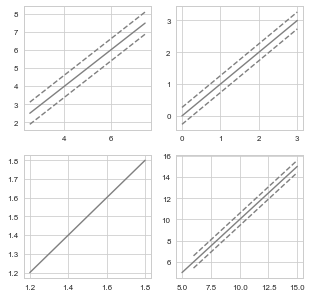

In [36]:
sns.set_context('paper')
plt.rcParams['font.size'] = 10.0
f = plt.figure(figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(2, 2,wspace=0.2)
ax1 = plt.subplot(gs[0,0])
ax0 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[1,1])

t=6.0 # days

# ---- plot 1:1 line ----
ax0.plot(np.linspace(0,3,20),np.linspace(0,3,20), '-',color='0.5')
ax1.plot(np.linspace(2.5,7.5,20),np.linspace(2.5,7.5,20), '-', color='0.5')
ax2.plot(np.linspace(5, 15, 20),np.linspace(5,15, 20),'-', color='0.5')
ax3.plot(np.linspace(1.2, 1.8, 20),np.linspace(1.2, 1.8, 20),'-', color='0.5')

# ---- plot error -----
# MSE ax0    
phi_array = np.array([(rec.Nbe_scaled/rec.N)**2 for rec in records_epsilon])
sca_array = np.array([(rec.Nbe)**2/(rec.N**2)  for rec in records_epsilon])
x_fit = np.linspace(0, 3, 50)
mean_sq_err = np.nanmean(((phi_array)-(sca_array))**2)
upper_bound = ax0.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax0.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax1    
phi_array = np.array([(rec.Nab_scaled/rec.N)**2 for rec in records_epsilon])
sca_array = np.array([(rec.Nab)**2/(rec.N**2) for rec in records_epsilon])
x_fit = np.linspace(2.5,7.5, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax2    
phi_array = np.array([rec.N_eff_scaled/1E-3 for rec in records_epsilon])
sca_array = np.array([rec.Neff/1E-3 for rec in records_epsilon])
x_fit = np.linspace(6,15, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax2.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax2.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax3    
phi_array = np.squeeze(np.array([rec.Tr_scaled_simple/rec.Tr0 for rec in records_epsilon]))
sca_array = np.squeeze(np.array([rec.Tr/rec.Tr0 for rec in records_epsilon]))
x_fit = np.linspace(1.2,1.8, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax3.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax3.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# ---- plot scaling ----
for rec in records_real:
    
    plt0 = ax0.plot((rec.Nbe_scaled/rec.N)**2,(rec.Nbe)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 6,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2)
      
    plt1 = ax1.plot((rec.Nab_scaled/rec.N)**2,(rec.Nab)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 6,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2) 
    
    plt2 = ax2.plot(rec.N_eff_scaled/1E-3,rec.Neff/1E-3,
                    marker = rec.mstyle,
                    markersize = 6,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2)
    plt3 = ax3.plot(rec.Tr_scaled_simple/rec.Tr0,
                    (rec.Tr/rec.Tr0),
                     marker = rec.mstyle,
                     markersize = 6,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=0.5,
                     markeredgecolor = 'k',
                     label=rec.label2)

    
    
# ---- aesthetics -----
ax0.set_xlim(0,3)
ax0.set_ylim(0,3)

ax1.set_xlim(2.5,7.5)
ax1.set_ylim(2.5,7.5)

ax2.set_xlim(6,14)
ax2.set_ylim(6,14)

ax3.set_xlim(1.2,1.75)
ax3.set_ylim(1.2,1.75)


ax0.set_ylabel('min $N^2/N^2_0$',labelpad=-1.5)
ax1.set_ylabel('max $N^2/N^2_0$',labelpad=-1.5)

ax0.set_xlabel(r'%1.1f$S$ + %1.1f$S^-_{dif}$ - %1.1f' %(reg_be.coef_[0], reg_be.coef_[1], -reg_be.intercept_)
               ,labelpad=0.5)
ax1.set_xlabel(r'%1.1f$S$ + %1.1f$S^+_{dif}$ - %1.1f' %(reg_ab.coef_[0], reg_ab.coef_[1], -reg_ab.intercept_)
               ,labelpad=0.5)

ax1.text(2.8,6.9,'Eqn.22')
ax0.text(0.2,2.7,'Eqn.23')
ax2.text(6.5,13.0,'Eqn.26')
ax3.text(1.25,1.68,'Eqn.24')

ax2.set_ylabel('$N_{eff}$ model / $10^{-3}$ s$^{-1}$', labelpad=0)
ax2.set_xlabel('$N_{eff}$ scaled / $10^{-3}$ s$^{-1}$',labelpad=0.0)

ax3.set_ylabel(r'$C_{rim}$ model /$C_0$', labelpad=0)
ax3.set_xlabel(r'$C_{rim}$ scaled /$C_0$', labelpad=0.0)

ax0.legend(bbox_to_anchor=(1.05,1.3), ncol=1,columnspacing=0.1,labelspacing=0.1,frameon=True )

ax0.tick_params(axis='x', pad=2)
ax1.tick_params(axis='x', pad=2)
ax2.tick_params(axis='x', pad=2)
ax3.tick_params(axis='x', pad=2)

ax0.tick_params(axis='y', pad=2)
ax1.tick_params(axis='y', pad=2)
ax2.tick_params(axis='y', pad=2)
ax3.tick_params(axis='y', pad=2)

ax0.set_aspect(1)
ax1.set_aspect(1)
ax2.set_aspect(1)
ax3.set_aspect(1)

ax1.text(0.9,0.05,'(a)',transform=ax1.transAxes)
ax0.text(0.9,0.05,'(b)',transform=ax0.transAxes)
ax3.text(0.9,0.05,'(c)',transform=ax3.transAxes)
ax2.text(0.9,0.05,'(d)',transform=ax2.transAxes)

plt.savefig('figure10_v2.eps',format='eps',bbox_inches='tight')


### Figure 10

In [ ]:
sns.set_context('paper')
plt.rcParams['font.size'] = 10.0
f = plt.figure(figsize = (6,3)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])

t=6.0 # days

# ---- plot 1:1 lines ----
ax0.plot(np.linspace(0,7,50),np.linspace(0,7,50),'-', color='0.5')
ax1.plot(np.linspace(0,5.5,50),np.linspace(0,5.5,50),'-', color='0.5')

# ---- plot errors ----
# MSE ax0    
phi_array = np.array([rec.Phi/1E4 for rec in records_dyn])
sca_array = np.array([rec.Phi_scaled/1E4  for rec in records_dyn])
x_fit = np.linspace(0,8, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax0.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax0.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax1    
phi_array = np.array([rec.PhiTr_scaled/1E5 for rec in records_epsilon])
sca_array = np.array([rec.PhiTr/1E5 for rec in records_epsilon])
x_fit = np.linspace(0,6, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# ---- plot scaling ----
for rec in records_real:
    
    plt1 = ax0.errorbar(rec.Phi_scaled/1E4,
                        rec.Phi/1E4,
                        yerr=rec.Phi_std/1E4,
                        marker = rec.mstyle,
                        markersize = 7,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=0.5,
                        markeredgecolor = 'k',
                        label=rec.label2)
    plt1 = ax1.errorbar(rec.PhiTr_scaled/1E5,
                        rec.PhiTr/1E5,
                        yerr=rec.PhiTr_std/1E5,
                        marker = rec.mstyle,
                        markersize = 7,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=0.5,
                        markeredgecolor = 'k',
                        label=rec.label2)


# ---- aesthetics ----
ax0.set_ylabel('Phi',labelpad=0.5)
ax0.set_ylabel('Upwelling flux / $10^4$ m$^3$s$^{-1}$', labelpad=-0.5)
ax1.set_ylabel('Tracer flux / $10^5$ $\mu$Mm$^3$s$^{-1}$', labelpad=-0.5)

ax0.set_xlabel(r'$\Phi$ / $10^4$ m$^3$s$^{-1}$', labelpad=-0.5 )
ax1.set_xlabel(r'$\Phi_{Tr}$ / $10^5$ $\mu$Mm$^3$s$^{-1}$', labelpad=-0.5)

ax0.set_xlim(0,7)
ax0.set_ylim(0,7)

ax1.set_xlim(0,5.5)
ax1.set_ylim(0,5.5)

ax0.text(0.5,6.3,'Eqn. 27')
ax1.text(0.5,5,'Eqn. 28')

ax0.text(0.9,0.05,'(a)',transform=ax0.transAxes)
ax1.text(0.9,0.05,'(b)',transform=ax1.transAxes)

ax0.tick_params(axis='x', pad=2)
ax1.tick_params(axis='x', pad=2)

ax0.tick_params(axis='y', pad=2)
ax1.tick_params(axis='y', pad=2)

ax0.set_aspect(1)
ax1.set_aspect(1)

plt.savefig('figure11_v2.eps',format='eps',bbox_inches='tight')


In [ ]:
print ("\t".join(['Experiment &','$\kappa_{bg}$ &','$\kappa_{can}$&','$\epsilon$&',
                 ]))

    
for rec in records_sel:
     print ("\t".join(['%s\t&$%0.2e$\t&$%0.2e$\t&$%1.0f$ ' 
                      % (rec.label2,
                         rec.kbg,
                         rec.kv, 
                         rec.epsilon,
                         )
                       ]))

In [ ]:
print ("\t".join(['Experiment &', '$N$ (s$^{-1}$)$&', 
                  '$f$ (s$^{-1}$)&', 'U (ms$^{-1}$)&', '$Bu$&', '$Ro$' ,
                 ]))

    
for rec in records_sel:
     print ("\t".join(['%s\t&\t&$%.1e$\t&$%.2e$\t&$%.2f$\t&$%.2f$\t&$%.2f$\t ' 
                      % (rec.label2, 
                         rec.N,
                         rec.f,
                         rec.u_mod,
                         Bu(rec.N, rec.f,W,Hs),
                         Ro(U=rec.u_mod, f=rec.f, R=L),
                         )
                       ]))

In [ ]:
print ("\t".join(['Exp name&','Phi 1E4&','PhiTr 1E5&', 'Total HCW $10^{10}$ m$^3$&', 
                  'CanyonHCW (%)&',  'TotTrMassHCW $10^{11}$ $\mu$Mm$^3$&', 'CanyonTrMassHCW (%)&',
                  'TotalTrMass $10^{11}$ $\mu$Mm$^3$&', 'CanyonTrMass (%) ' ]))

    
for rec,recNoC in zip(records_sel,records_selNoC):
    
    
    print ("\t".join(['%s\t&%0.2f$\pm$%0.2f\t&%0.2f$\pm$ %0.2f\t&%.2f\t&%.2f\t\t&%.2f\t\t&%.2f\t&%.2f\t\t&%.2f\t ' 
                      % (rec.label2,
                         rec.Phi/1E4,rec.Phi_std/1E4,
                         rec.PhiTr/1E5, rec.PhiTr_std/1E5,
                         (rec.HCW[18]-rec.HCW[0])/1E10,
                         (((rec.HCW[18]-rec.HCW[0])-(recNoC.HCW[18]-recNoC.HCW[0]))/(rec.HCW[18]-rec.HCW[0]))*100,
                         (rec.TrMass[18]-rec.TrMass[0])/1E11,
                         (((rec.TrMass[18]-rec.TrMass[0])-
                           (recNoC.TrMass[18]-recNoC.TrMass[0]))/(rec.TrMass[18]-rec.TrMass[0]))*100,
                         (rec.TrMassTot[18]-rec.TrMassTot[0])/1E11,
                         (((rec.TrMassTot[18]-rec.TrMassTot[0]-
                            recNoC.TrMassTot[18]+recNoC.TrMassTot[0]))/(rec.TrMassTot[18]-rec.TrMassTot[0]))*100)
                     ]))
    

In [ ]:
(50**2/1E-5)/(100**2/(1E-2-1E-5))

In [ ]:
(50**2/1E-5)/(50**2/(1E-2-1E-5))
